2022-04-21 10:10:36.114982: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-21 10:10:36.116090: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-21 10:10:36.118608: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Found 2000 images belonging to 2 classes.


2022-04-21 10:10:36.870001: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-04-21 10:10:36.894136: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2499995000 Hz


Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 2s 18ms/step - loss: 0.5692 - accuracy: 0.6805 - val_loss: 0.3022 - val_accuracy: 0.8800
Epoch 2/30
100/100 [==============================] - 2s 21ms/step - loss: 0.3005 - accuracy: 0.8726 - val_loss: 0.2576 - val_accuracy: 0.9020
Epoch 3/30
100/100 [==============================] - 1s 14ms/step - loss: 0.2349 - accuracy: 0.9055 - val_loss: 0.2446 - val_accuracy: 0.9050
Epoch 4/30
100/100 [==============================] - 1s 13ms/step - loss: 0.1906 - accuracy: 0.9199 - val_loss: 0.2414 - val_accuracy: 0.9090
Epoch 5/30
100/100 [==============================] - 1s 13ms/step - loss: 0.1579 - accuracy: 0.9507 - val_loss: 0.2675 - val_accuracy: 0.8870
Epoch 6/30
100/100 [==============================] - 1s 13ms/step - loss: 0.1319 - accuracy: 0.9534 - val_loss: 0.2358 - val_accuracy: 0.9080
Epoch 7/30
100/100 [==============================] - 1s 1

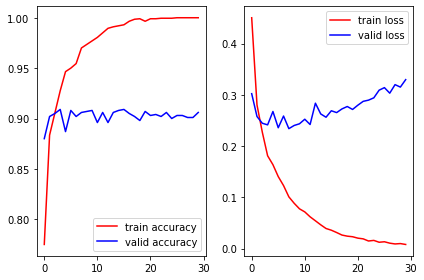

In [1]:
### Transfer Learning ###

### keras는 전이학습을 위해서 VGG16을 제공해줘요!
from tensorflow.keras.applications import VGG16

model_base = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(150,150,3))

## 우리가 가지고 있는 데이터(개와 고양이)를 VGG16에 통과시켜서
## 이미지의 특성을 ndarray형태로 저장해야 해요!

import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = './data/cat_dog_small'
train_dir = os.path.join(base_dir, 'train')  # ./data/cat_dog_small/train
valid_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1/255)

def extraction_feature(directory, sample_count):
    features = np.zeros(shape=(sample_count,4,4,512))
    labels = np.zeros(shape=(sample_count,))
    
    generator = datagen.flow_from_directory(
        directory,
        classes=['cats', 'dogs'],
        target_size=(150,150),
        batch_size=20,
        class_mode='binary'
    )
    
    i = 0
    
    for x_data_batch, t_data_batch in generator:
        feature_batch = model_base.predict(x_data_batch)  # 20개 이미지 특성추출.
        features[i*20:(i+1)*20] = feature_batch
        labels[i*20:(i+1)*20] = t_data_batch
        
        i = i + 1
        
        if i*20 >= sample_count:
            break
            
    return features, labels
    

train_features, train_labels = extraction_feature(train_dir, 2000)
valid_features, valid_labels = extraction_feature(valid_dir, 1000)
test_features, test_labels = extraction_feature(test_dir, 1000)

## 이 ndarray를 이용해서 DNN 학습을 하면 될 거 같아요!

train_x_data = np.reshape(train_features,(2000,4*4*512))  # 2차원
train_t_data = train_labels

valid_x_data = np.reshape(valid_features,(1000,4*4*512))  # 2차원
valid_t_data = valid_labels

test_x_data = np.reshape(test_features,(1000,4*4*512))  # 2차원
test_t_data = test_labels

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential()

model.add(Flatten(input_shape=(4*4*512,)))

model.add(Dense(units=256,
                activation='relu'))
model.add(Dropout(rate=0.5))

model.add(Dense(units=1,
                activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_x_data,
                    train_t_data,
                    epochs=30,
                    batch_size=20,
                    validation_data=(valid_x_data, valid_t_data))

### history 객체를 이용해서 결과 그래프를 그려보아요!! ###

import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
valid_acc = history.history['val_accuracy']

train_loss = history.history['loss']
valid_loss = history.history['val_loss']

figure = plt.figure()
ax1 = figure.add_subplot(1,2,1)
ax2 = figure.add_subplot(1,2,2)

ax1.plot(train_acc, color='r', label='train accuracy')
ax1.plot(valid_acc, color='b', label='valid accuracy')
ax1.legend()

ax2.plot(train_loss, color='r', label='train loss')
ax2.plot(valid_loss, color='b', label='valid loss')
ax2.legend()

plt.tight_layout()
plt.show()

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 - 185s - loss: 0.6151 - accuracy: 0.6630 - val_loss: 0.4447 - val_accuracy: 0.7880
Epoch 2/30
100/100 - 181s - loss: 0.5040 - accuracy: 0.7450 - val_loss: 0.3452 - val_accuracy: 0.8450
Epoch 3/30
100/100 - 182s - loss: 0.4569 - accuracy: 0.7935 - val_loss: 0.3139 - val_accuracy: 0.8650
Epoch 4/30
100/100 - 181s - loss: 0.4302 - accuracy: 0.8050 - val_loss: 0.3480 - val_accuracy: 0.8450
Epoch 5/30
100/100 - 181s - loss: 0.4160 - accuracy: 0.8120 - val_loss: 0.3131 - val_accuracy: 0.8550
Epoch 6/30
100/100 - 181s - loss: 0.3999 - accuracy: 0.8285 - val_loss: 0.3209 - val_accuracy: 0.8520
Epoch 7/30
100/100 - 181s - loss: 0.3886 - accuracy: 0.8060 - val_loss: 0.2936 - val_accuracy: 0.8660
Epoch 8/30
100/100 - 182s - loss: 0.3801 - accuracy: 0.8275 - val_loss: 0.2986 - val_accuracy: 0.8620
Epoch 9/30
100/100 - 181s - loss: 0.3791 - accuracy: 0.8290 - val_loss: 0.2810 - val_accuracy: 0.873

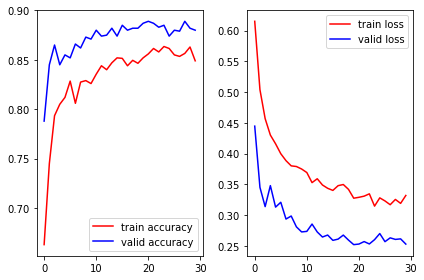

In [8]:
### 이미지 증식을 이용한 전이학습 ###

import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

train_dir = './data/cat_dog_small/train'
valid_dir = './data/cat_dog_small/validation'

train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=30,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    classes=['cats', 'dogs'],
                                                    target_size=(150,150),
                                                    batch_size=20,
                                                    class_mode='binary') # categorical(다중분류인 경우)

valid_generator = valid_datagen.flow_from_directory(valid_dir,
                                                    classes=['cats', 'dogs'],
                                                    target_size=(150,150),
                                                    batch_size=20,
                                                    class_mode='binary') # categorical(다중분류인 경우)

# Pretrained Network
model_base = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(150,150,3))

model_base.trainable = False  # Convolution layer안의 parameter 동결!

# model 구현

model = Sequential()

model.add(model_base)

model.add(Flatten(input_shape=(4*4*512,)))

model.add(Dense(units=256,
                activation='relu'))

model.add(Dropout(rate=0.5))

model.add(Dense(units=1,
                activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=30,
                    validation_data=valid_generator,
                    validation_steps=50,
                    verbose=2)

model.save('./data/cat_dog_small/transfer_learning_cnn_cat_dog_small.h5')

### history 객체를 이용해서 결과 그래프를 그려보아요!! ###

import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
valid_acc = history.history['val_accuracy']

train_loss = history.history['loss']
valid_loss = history.history['val_loss']

figure = plt.figure()
ax1 = figure.add_subplot(1,2,1)
ax2 = figure.add_subplot(1,2,2)

ax1.plot(train_acc, color='r', label='train accuracy')
ax1.plot(valid_acc, color='b', label='valid accuracy')
ax1.legend()

ax2.plot(train_loss, color='r', label='train loss')
ax2.plot(valid_loss, color='b', label='valid loss')
ax2.legend()

plt.tight_layout()
plt.show()